#Recurrent Neural Networks

While CNNs can efficiently process spatial information, recurrent neural networks (RNNs) are designed to better handle sequential information. RNNs introduce state variables to store past information, together with the current inputs, to determine the current outputs. <br>
Many of the examples for using recurrent networks are based on text data. Hence, we will emphasize language models in this chapter. After a more formal review of sequence data we introduce practical techniques for preprocessing text data. Next, we discuss basic concepts of a language model and use this discussion as the inspiration for the design of RNNs. In the end, we describe the gradient calculation method for RNNs to explore problems that may be encountered when training such networks.

## 8.1. Sequence Models

### 8.1.2. Training

To keep things simple we generate our sequence data by using a sine function with some additive noise for time steps 1,2,...,1000.

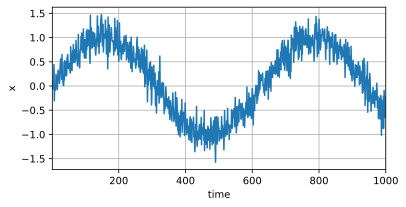

In [ ]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

T = 1000  # Generate a total of 1000 points
time = tf.range(1, T + 1, dtype=tf.float32)
x = tf.sin(0.01 * time) + tf.random.normal([T], 0, 0.2)
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [ ]:
# Here we only use the first 600 feature-label pairs for training.
tau = 4
features = tf.Variable(tf.zeros((T - tau, tau)))
for i in range(tau):
    features[:, i].assign(x[i: T - tau + i])
labels = tf.reshape(x[tau:], (-1, 1))

batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [ ]:
#Here we keep the architecture fairly simple: just an MLP with two fully-connected layers, ReLU activation, and squared loss.

# Vanilla MLP architecture
def get_net():
    net = tf.keras.Sequential([tf.keras.layers.Dense(10, activation='relu'),
                              tf.keras.layers.Dense(1)])
    return net

# Note: `MeanSquaredError` computes squared error without the 1/2 factor
loss = tf.keras.losses.MeanSquaredError()

In [ ]:
def train(net, train_iter, loss, epochs, lr):
    trainer = tf.keras.optimizers.Adam()
    for epoch in range(epochs):
        for X, y in train_iter:
            with tf.GradientTape() as g:
                out = net(X)
                l = loss(y, out)
                params = net.trainable_variables
                grads = g.gradient(l, params)
            trainer.apply_gradients(zip(grads, params))
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 1.197221
epoch 2, loss: 0.660972
epoch 3, loss: 0.357645
epoch 4, loss: 0.193874
epoch 5, loss: 0.116552


### 8.1.3. Prediction

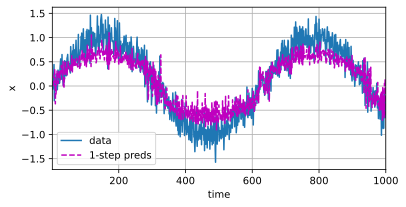

In [ ]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.numpy(), onestep_preds.numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

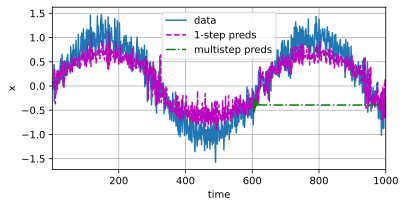

In [ ]:
multistep_preds = tf.Variable(tf.zeros(T))
multistep_preds[:n_train + tau].assign(x[:n_train + tau])
for i in range(n_train + tau, T):
    multistep_preds[i].assign(tf.reshape(net(
        tf.reshape(multistep_preds[i - tau: i], (1, -1))), ()))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.numpy(), onestep_preds.numpy(),
          multistep_preds[n_train + tau:].numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

As the above example shows, this is a spectacular failure. The predictions decay to a constant pretty quickly after a few prediction steps. 


Let us take a closer look at the difficulties in $k$-step-ahead predictions
by computing predictions on the entire sequence for $k = 1, 4, 16, 64$.

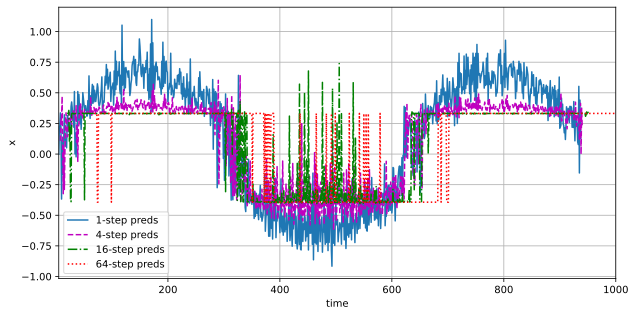

In [ ]:
max_steps = 64

features = tf.Variable(tf.zeros((T - tau - max_steps + 1, tau + max_steps)))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i].assign(x[i: i + T - tau - max_steps + 1].numpy())

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i].assign(tf.reshape(net((features[:, i - tau: i])), -1))

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(10, 5))

## 8.2. Text Preprocessing

To facilitate our future experiments with sequence data, we will dedicate this section to explain common preprocessing steps for text. Usually, these steps are:


1.   Load text as strings into memory.
2.   Split strings into tokens (e.g., words and characters).
3.   Build a table of vocabulary to map the split tokens to numerical indices.
4.   Convert text into sequences of numerical indices so they can be manipulated by models easily.








In [ ]:
import collections
import re
from d2l import tensorflow as d2l

### 8.2.1. Reading the Dataset

In [ ]:
#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """Load the time machine dataset into a list of text lines."""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


### 8.2.2. Tokenization

The following tokenize function takes a list (lines) as the input, where each element is a text sequence (e.g., a text line). Each text sequence is split into a list of tokens. A token is the basic unit in text. In the end, a list of token lists are returned, where each token is a string.

In [ ]:
def tokenize(lines, token='word'):  #@save
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


### 8.2.3. Vocabulary

In [ ]:
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

def count_corpus(tokens):  #@save
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

We construct a vocabulary using the time machine dataset as the corpus. Then we print the first few frequent tokens with their indices.

In [ ]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [ ]:
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


### 8.2.4. Putting All Things Together

The modifications we did here are: (i) we tokenize text into characters, not words, to simplify the training in later sections; (ii) corpus is a single list, not a list of token lists, since each text line in the time machine dataset is not necessarily a sentence or a paragraph

In [ ]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

## 8.3. Language Models and the Dataset

Nonetheless, language models are of great service even in their limited form. For instance, the phrases “to recognize speech” and “to wreck a nice beach” sound very similar. This can cause ambiguity in speech recognition, which is easily resolved through a language model that rejects the second translation as outlandish. Likewise, in a document summarization algorithm it is worthwhile knowing that “dog bites man” is much more frequent than “man bites dog”, or that “I want to eat grandma” is a rather disturbing statement, whereas “I want to eat, grandma” is much more benign.

### 8.3.3. Natural Language Statistics

Let us see how this works on real data. We construct a vocabulary based on the time machine dataset as introduced in Section 8.2 and print the top 10 most frequent words.

In [ ]:
import random
import tensorflow as tf
from d2l import tensorflow as d2l

tokens = d2l.tokenize(d2l.read_time_machine())
# Since each text line is not necessarily a sentence or a paragraph, we
# concatenate all text lines
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

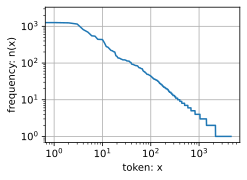

In [ ]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

 After all, we will significantly overestimate the frequency of the tail, also known as the infrequent words. But what about the other word combinations, such as bigrams, trigrams, and beyond? Let us see whether the bigram frequency behaves in the same manner as the unigram frequency.

In [ ]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

 Furthermore, let us see whether the trigram frequency behaves in the same manner.

In [ ]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

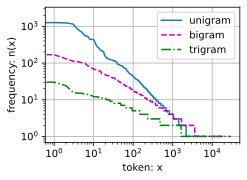

In [ ]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

### 8.3.4. Reading Long Sequence Data

When sequences get too long to be processed by models all at once, we may wish to split such sequences for reading. Before introducing the model, let us assume that we will use a neural network to train a language model, where the network processes a minibatch of sequences with predefined length, say n time steps, at a time. Now the question is how to read minibatches of features and labels at random.

#### 8.3.4.1. Random Sampling

In random sampling, each example is a subsequence arbitrarily captured on the original long sequence. The subsequences from two adjacent random minibatches during iteration are not necessarily adjacent on the original sequence. For language modeling, the target is to predict the next token based on what tokens we have seen so far, hence the labels are the original sequence, shifted by one token.

In [ ]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield tf.constant(X), tf.constant(Y)

We assume that
the batch size and numbers of time steps are 2 and 5,
respectively.
This means that we can generate $\lfloor (35 - 1) / 5 \rfloor= 6$ feature-label subsequence pairs. With a minibatch size of 2, we only get 3 minibatches.

In [ ]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tf.Tensor(
[[19 20 21 22 23]
 [ 4  5  6  7  8]], shape=(2, 5), dtype=int32) 
Y: tf.Tensor(
[[20 21 22 23 24]
 [ 5  6  7  8  9]], shape=(2, 5), dtype=int32)
X:  tf.Tensor(
[[ 9 10 11 12 13]
 [24 25 26 27 28]], shape=(2, 5), dtype=int32) 
Y: tf.Tensor(
[[10 11 12 13 14]
 [25 26 27 28 29]], shape=(2, 5), dtype=int32)
X:  tf.Tensor(
[[14 15 16 17 18]
 [29 30 31 32 33]], shape=(2, 5), dtype=int32) 
Y: tf.Tensor(
[[15 16 17 18 19]
 [30 31 32 33 34]], shape=(2, 5), dtype=int32)


#### 8.3.4.2. Sequential Partitioning

In addition to random sampling of the original sequence, we can also ensure that the subsequences from two adjacent minibatches during iteration are adjacent on the original sequence. This strategy preserves the order of split subsequences when iterating over minibatches, hence is called sequential partitioning.

In [ ]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = tf.constant(corpus[offset: offset + num_tokens])
    Ys = tf.constant(corpus[offset + 1: offset + 1 + num_tokens])
    Xs = tf.reshape(Xs, (batch_size, -1))
    Ys = tf.reshape(Ys, (batch_size, -1))
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_batches * num_steps, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [ ]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tf.Tensor(
[[ 5  6  7  8  9]
 [19 20 21 22 23]], shape=(2, 5), dtype=int32) 
Y: tf.Tensor(
[[ 6  7  8  9 10]
 [20 21 22 23 24]], shape=(2, 5), dtype=int32)
X:  tf.Tensor(
[[10 11 12 13 14]
 [24 25 26 27 28]], shape=(2, 5), dtype=int32) 
Y: tf.Tensor(
[[11 12 13 14 15]
 [25 26 27 28 29]], shape=(2, 5), dtype=int32)


In [ ]:
class SeqDataLoader:  #@save
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [ ]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

## 8.4. Recurrent Neural Networks

Recurrent neural networks (RNNs) are neural networks with hidden states. Before introducing the RNN model, we first revisit the MLP model introduced in Section 4.1.

### 8.4.2. Recurrent Neural Networks with Hidden States

To begin with,
we define matrices `X`, `W_xh`, `H`, and `W_hh`, whose shapes are (3, 1), (1, 4), (3, 4), and (4, 4), respectively.
Multiplying `X` by `W_xh`, and `H` by `W_hh`, respectively, and then adding these two multiplications,
we obtain a matrix of shape (3, 4).


In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

X, W_xh = tf.random.normal((3, 1), 0, 1), tf.random.normal((1, 4), 0, 1)
H, W_hh = tf.random.normal((3, 4), 0, 1), tf.random.normal((4, 4), 0, 1)
tf.matmul(X, W_xh) + tf.matmul(H, W_hh)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[-1.5140115 ,  2.90554   ,  1.6808138 , -0.00645372],
       [ 2.065234  , -1.6634942 , -0.8531257 ,  5.6693153 ],
       [ 0.08132529, -0.0297181 ,  2.0099976 ,  3.5734782 ]],
      dtype=float32)>

Now we concatenate the matrices X and H along columns (axis 1), and the matrices W_xh and W_hh along rows (axis 0). These two concatenations result in matrices of shape (3, 5) and of shape (5, 4), respectively. Multiplying these two concatenated matrices, we obtain the same output matrix of shape (3, 4) as above.

In [ ]:
tf.matmul(tf.concat((X, H), 1), tf.concat((W_xh, W_hh), 0))

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[-1.5140115 ,  2.9055398 ,  1.6808138 , -0.00645373],
       [ 2.065234  , -1.6634942 , -0.85312563,  5.6693153 ],
       [ 0.08132529, -0.029718  ,  2.0099976 ,  3.573478  ]],
      dtype=float32)>

## 8.5. Implementation of Recurrent Neural Networks from Scratch

In this section we will implement an RNN from scratch for a character-level language model,

In [ ]:
%matplotlib inline
import math
import tensorflow as tf
from d2l import tensorflow as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

train_random_iter, vocab_random_iter = d2l.load_data_time_machine(
    batch_size, num_steps, use_random_iter=True)

### 8.5.1. One-Hot Encoding

The shape of the minibatch that we sample each time is (batch size, number of time steps). The one_hot function transforms such a minibatch into a three-dimensional tensor with the last dimension equals to the vocabulary size (len(vocab)). 

In [ ]:
X = tf.reshape(tf.range(10), (2, 5))
tf.one_hot(tf.transpose(X), 28).shape

TensorShape([5, 2, 28])

### 8.5.2. Initializing the Model Parameters

In [ ]:
def get_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return tf.random.normal(shape=shape,stddev=0.01,mean=0,dtype=tf.float32)

    # Hidden layer parameters
    W_xh = tf.Variable(normal((num_inputs, num_hiddens)), dtype=tf.float32)
    W_hh = tf.Variable(normal((num_hiddens, num_hiddens)), dtype=tf.float32)
    b_h = tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32)
    # Output layer parameters
    W_hq = tf.Variable(normal((num_hiddens, num_outputs)), dtype=tf.float32)
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    return params

### 8.5.3. RNN Model

In [ ]:
def init_rnn_state(batch_size, num_hiddens):
    return (tf.zeros((batch_size, num_hiddens)), )

The following rnn function defines how to compute the hidden state and output at a time step. Note that the RNN model loops through the outermost dimension of inputs so that it updates hidden states H of a minibatch, time step by time step. 

In [ ]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        X = tf.reshape(X,[-1,W_xh.shape[0]])
        H = tf.tanh(tf.matmul(X, W_xh) + tf.matmul(H, W_hh) + b_h)
        Y = tf.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return tf.concat(outputs, axis=0), (H,)

With all the needed functions being defined, next we create a class to wrap these functions and store parameters for an RNN model implemented from scratch.

In [ ]:
class RNNModelScratch: #@save
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens,
                 init_state, forward_fn, get_params):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.init_state, self.forward_fn = init_state, forward_fn
        self.trainable_variables = get_params(vocab_size, num_hiddens)

    def __call__(self, X, state):
        X = tf.one_hot(tf.transpose(X), self.vocab_size)
        X = tf.cast(X, tf.float32)
        return self.forward_fn(X, state, self.trainable_variables)

    def begin_state(self, batch_size, *args, **kwargs):
        return self.init_state(batch_size, self.num_hiddens)

In [ ]:
# defining tensorflow training strategy
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)

num_hiddens = 512
with strategy.scope():
    net = RNNModelScratch(len(vocab), num_hiddens, init_rnn_state, rnn,
                          get_params)
state = net.begin_state(X.shape[0])
Y, new_state = net(X, state)
Y.shape, len(new_state), new_state[0].shape

(TensorShape([10, 28]), 1, TensorShape([2, 512]))

### 8.5.4. Prediction

Let us first define the prediction function to generate new characters following the user-provided prefix, which is a string containing several characters. When looping through these beginning characters in prefix, we keep passing the hidden state to the next time step without generating any output. This is called the warm-up period, during which the model updates itself (e.g., update the hidden state) but does not make predictions. After the warm-up period, the hidden state is generally better than its initialized value at the beginning. So we generate the predicted characters and emit them.

In [ ]:
def predict_ch8(prefix, num_preds, net, vocab):  #@save
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, dtype=tf.float32)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: tf.reshape(tf.constant([outputs[-1]]), (1, 1)).numpy()
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.numpy().argmax(axis=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [ ]:
predict_ch8('time traveller ', 10, net, vocab)

'time traveller gkmymwgrui'

### 8.5.5. Gradient Clipping

Below we define a function to clip the gradients of a model that is implemented from scratch or a model constructed by the high-level APIs. Also note that we compute the gradient norm over all the model parameters.

In [ ]:
def grad_clipping(grads, theta):  #@save
    """Clip the gradient."""
    theta = tf.constant(theta, dtype=tf.float32)
    new_grad = []
    for grad in grads:
        if isinstance(grad, tf.IndexedSlices):
            new_grad.append(tf.convert_to_tensor(grad))
        else:
            new_grad.append(grad)
    norm = tf.math.sqrt(sum((tf.reduce_sum(grad ** 2)).numpy()
                        for grad in new_grad))
    norm = tf.cast(norm, tf.float32)
    if tf.greater(norm, theta):
        for i, grad in enumerate(new_grad):
            new_grad[i] = grad * theta / norm
    else:
        new_grad = new_grad
    return new_grad

### 8.5.6. Training

Before training the model, let us define a function to train the model in one epoch.

In [ ]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, use_random_iter):
    """Train a model within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], dtype=tf.float32)
        with tf.GradientTape(persistent=True) as g:
            y_hat, state = net(X, state)
            y = tf.reshape(tf.transpose(Y), (-1))
            l = loss(y, y_hat)
        params = net.trainable_variables
        grads = g.gradient(l, params)
        grads = grad_clipping(grads, 1)
        updater.apply_gradients(zip(grads, params))

        # Keras loss by default returns the average loss in a batch
        # l_sum = l * float(d2l.size(y)) if isinstance(
        #     loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l * d2l.size(y), d2l.size(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [ ]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, strategy,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    with strategy.scope():
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        updater = tf.keras.optimizers.SGD(lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    device = d2l.try_gpu()._device_name
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

Now we can train the RNN model. Since we only use 10000 tokens in the dataset, the model needs more epochs to converge better.

perplexity 1.0, 10198.7 tokens/sec on /GPU:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


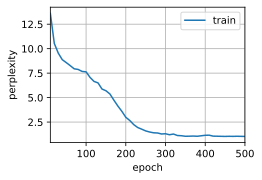

In [ ]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, strategy)

Finally, let us check the results of using the random sampling method.

perplexity 1.5, 9966.9 tokens/sec on /GPU:0
time traveller smiled are you sure we can move freely inspace ri
traveller smiled are you sure we can move freely inspace ri


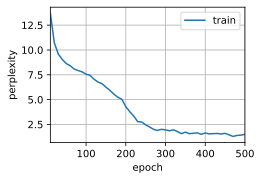

In [ ]:
with strategy.scope():
    net = RNNModelScratch(len(vocab), num_hiddens, init_rnn_state, rnn,
                          get_params)
train_ch8(net, train_iter, vocab_random_iter, lr, num_epochs, strategy,
          use_random_iter=True)

## 8.6. Concise Implementation of Recurrent Neural Networks

This section will show how to implement the same language model more efficiently using functions provided by high-level APIs of a deep learning framework. We begin as before by reading the time machine dataset.

In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### 8.6.1. Defining the Model

For now, suffice it to say that multiple layers simply amount to the output of one layer of RNN being used as the input for the next layer of RNN.

In [ ]:
num_hiddens = 256
rnn_cell = tf.keras.layers.SimpleRNNCell(num_hiddens,
    kernel_initializer='glorot_uniform')
rnn_layer = tf.keras.layers.RNN(rnn_cell, time_major=True,
    return_sequences=True, return_state=True)

state = rnn_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
state.shape

TensorShape([32, 256])

In [ ]:
X = tf.random.uniform((num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, len(state_new), state_new[0].shape

(TensorShape([35, 32, 256]), 32, TensorShape([256]))

In [ ]:
#@save
class RNNModel(tf.keras.layers.Layer):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, state):
        X = tf.one_hot(tf.transpose(inputs), self.vocab_size)
        # Later RNN like `tf.keras.layers.LSTMCell` return more than two values
        Y, *state = self.rnn(X, state)
        output = self.dense(tf.reshape(Y, (-1, Y.shape[-1])))
        return output, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.cell.get_initial_state(*args, **kwargs)

### 8.6.2. Training and Predicting

Before training the model, let us make a prediction with the a model that has random weights.

In [ ]:
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)
with strategy.scope():
    net = RNNModel(rnn_layer, vocab_size=len(vocab))

d2l.predict_ch8('time traveller', 10, net, vocab)

'time travellerhw eb qxkk'

perplexity 1.4, 14784.2 tokens/sec on /GPU:0
time traveller but now you begin to seethe object of my investig
travelleromy that fore dimensions ane the gome traund fing 


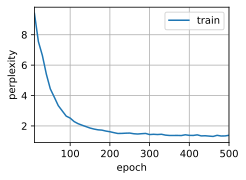

In [ ]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, strategy)